# 08 MNIST experiment
An experiment consisting of such steps:
1. Create a toy MNIST problem classifying only between 0 and 8.
2. Train a CNN classifier on the data
3. generate an attribution map of the classifier (should focus somewhere to the center)
4. Check if the attribution maps are correct. If false, use RRR to fix them.

The main goal of this experiment is to smoothly introduce usage of RRR as well as show usefulness of the algorithm

## 1.1 Dataset preparation

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import torchvision.datasets as tds
from torchvision.transforms import ToTensor, Lambda
from lovely_tensors import monkey_patch
monkey_patch()
import torch

num_classes = 2

ds_train = tds.MNIST(
    root="data/",
    train=True,
    download=True,
    transform=ToTensor(),
    # target_transform=Lambda(lambda y: torch.zeros(2, dtype=torch.float).scatter_(0, torch.tensor(0 if y == 0 else 1 if y == 8 else 2), value=1)) 
)

# target transformation according to "output: 3 possible outputs (0: out of problem label, 1: number 0, 2: number 8)"
ds_test = tds.MNIST(
    root="data/",
    train=False,
    download=True,
    transform=ToTensor(),
    # target_transform=Lambda(lambda y: torch.zeros(2, dtype=torch.float).scatter_(0, torch.tensor(0 if y == 0 else 1 if y == 8 else 2), value=1))
)

train_dataset_length = -1

labels = [0, 8]
train_indices = [i for i, (_, label) in enumerate(ds_train) if label in labels][:train_dataset_length]
test_indices = [i for i, (_, label) in enumerate(ds_test) if label in labels]
ds_train = torch.utils.data.Subset(ds_train, train_indices)
ds_test = torch.utils.data.Subset(ds_test, test_indices)

# Set target_transform attribute
target_transform = Lambda(lambda y: torch.zeros(2, dtype=torch.float).scatter_(0, torch.tensor(0 if y == 0 else 1), value=1))
ds_train.dataset.target_transform = target_transform
ds_test.dataset.target_transform = target_transform


Length of ds_train: 11773; length of ds_test: 1954
shape of x[0]: torch.Size([1, 28, 28])
y[0]: tensor[2] μ=0.500 σ=0.707 [1.000, 0.]


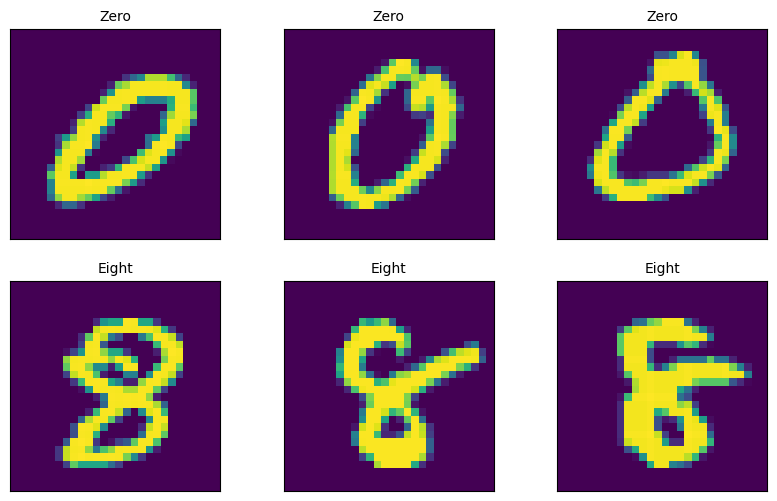

In [7]:
print(f"Length of ds_train: {len(ds_train)}; length of ds_test: {len(ds_test)}")
first = ds_train[0]
first_x = first[0]
print("shape of x[0]:", first_x.shape)
print("y[0]:", first[1])
size_1_dim = first_x.shape[1] * first_x.shape[2]

import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
# fig.subplots_adjust(wspace=0, hspace=0)

# Show 3 instances for each of the 2 labels
label_translation = dict(zero=torch.tensor((1, 0)), eight=torch.tensor((0, 1)))
zeros = []
eights = []
example_dataloader = torch.utils.data.DataLoader(ds_train, batch_size=1, shuffle=True)
for i, (X, y) in enumerate(example_dataloader):
    X = torch.flatten(X, 0, 2)
    if all(y[0] == label_translation["zero"]) and len(zeros) != 3:
        zeros.append(X)
    elif all(y[0] == label_translation["eight"]) and len(eights) != 3:
        eights.append(X)
    
    if len(zeros) == 3 and len(eights) == 3:
        break
    
for i, X in enumerate(zeros):
    ax_list[0][i].imshow(X, cmap='viridis')
    ax_list[0][i].set_title("Zero", fontsize=10, color='black')
    ax_list[0][i].set_xticks([])
    ax_list[0][i].set_yticks([])
    # ax_list[0][i].set_facecolor('black')

for i, X in enumerate(eights):
    ax_list[1][i].imshow(X, cmap='viridis')
    ax_list[1][i].set_title("Eight", fontsize=10, color='black')
    ax_list[1][i].set_xticks([])
    ax_list[1][i].set_yticks([])
    # ax_list[1][i].set_facecolor('black')

## 1.2 CNN definition

In [2]:
from torch.nn import Sequential, Conv2d, MaxPool2d, Flatten, ReLU, Linear, Dropout, Softmax

# input: 28X28 images
# output: 3 possible outputs (0: out of problem label, 1: number 0, 2: number 1)

model = Sequential(
    # 1st group
    Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2, return_indices=False), #return_indices=True is apparently needed to compute second-order derivatives
    # 2nd group
    Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2, return_indices=False),
    # TODO: maybe 3rd group
    # Flattening into 1d array
    Flatten(),
    # Dense layers (aka Fully-connected layers)
    Linear(in_features=32 * 7 * 7, out_features=128), # maxpooling reduces dimensionality by half, 7 = 28 (image_size) / (2 * 2)
    ReLU(),
    Linear(in_features=128, out_features=num_classes),
    Softmax(dim=1)
)
# model.eval()
def reset_parameters(model):
    for layer in model:
        try:
            layer.reset_parameters()
        except AttributeError:
            print(f"layer of type {type(layer)} does not have function `reset_parameters")



In [4]:
# Print info about data to understand what type of dataset we have


from torch.utils.data import DataLoader
from src.utils import XILUtils
t_dl = DataLoader(ds_train, batch_size=4)
device = XILUtils.define_device()
print(device)
test_model = model.to(device)
for batch, (X, y) in enumerate(t_dl):
    X = X.to(device)
    y = y.to(device)
    print(X.device, y.device)
    print(X, y)
    print(f"Shape of X: {X.shape}, shape of y: {y.shape}")
    test_model.eval()
    output = test_model(X)
    print(output.shape)
    print(output)
    break

mps
mps:0 mps:0
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

/Users/zlochinus/Library/Caches/pypoetry/virtualenvs/right_for_the_right_reasons_(rrr)_mlp-2BMFOOTm-py3.11/lib/python3.11/site-packages/torch/_tensor_str.py:145: UserWarning: MPS: nonzero op is supported natively starting from macOS 14.0. Falling back on CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Indexing.mm:361.)
  nonzero_finite_vals = torch.masked_select(


## 1.3 Training on MNIST dataset


In [45]:
import torch.nn.functional as F
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            # move X, y to device
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (F.one_hot(pred.argmax(1), num_classes=num_classes) == y).type(torch.float).sum().item() / num_classes

        test_loss /= num_batches
        correct /= size
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


In [27]:
from src.utils import XILUtils, ModelConfig
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
import torch.nn as nn

# move to the best device
device = XILUtils.define_device()
model = model.to(device)

lr = 0.001
# lr = 0.0001
batch_size = 64

# define optimizers
sgd_opt = SGD(model.parameters(), lr=lr, momentum=0.9)
adam_opt = Adam(model.parameters(), lr=lr)

# define loss function
#   data imbalance prevention
# class_weights = torch.tensor([0.02, 0.45, 0.45], dtype=torch.float32).to(device)
loss = nn.CrossEntropyLoss()

# create dataloader
train_dataloader = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(ds_test, batch_size=batch_size, shuffle=True)

# model config
conf = ModelConfig(batch_size=batch_size)

epochs = 5

for t in range(epochs):
    print(f"Epoch {t + 1}\n" + 20 * "-")
    
    # train loop 
    XILUtils.train_loop(train_dataloader, model, loss_fn=loss, optimizer=adam_opt, model_config=conf, device=device)
    
    # Evaluate the model
    test_loop(test_dataloader, model, loss_fn=loss, device=device)

print("Done!")


Epoch 1
--------------------
loss: 0.695016 [   64/  200]
Test Error: 
 Accuracy: 88.6%, Avg loss: 0.642453 

Epoch 2
--------------------
loss: 0.632572 [   64/  200]
Test Error: 
 Accuracy: 90.5%, Avg loss: 0.580178 

Epoch 3
--------------------
loss: 0.567739 [   64/  200]
Test Error: 
 Accuracy: 92.7%, Avg loss: 0.504745 

Epoch 4
--------------------
loss: 0.462145 [   64/  200]
Test Error: 
 Accuracy: 93.7%, Avg loss: 0.436601 

Epoch 5
--------------------
loss: 0.404014 [   64/  200]
Test Error: 
 Accuracy: 93.8%, Avg loss: 0.402143 

Done!


## 1.4 Applying explainers

### 1.4.1 Applying Grad-CAM


Example 0:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([1., 0.])
Predicted target: tensor([1., 0.]) with 97.917% certainty. Correct? True

Example 1:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([0., 1.])
Predicted target: tensor([0., 1.]) with 97.750% certainty. Correct? True

Example 2:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([1., 0.])
Predicted target: tensor([1., 0.]) with 98.517% certainty. Correct? True

Example 3:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([0., 1.])
Predicted target: tensor([0., 1.]) with 94.715% certainty. Correct? True

Example 4:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([1., 0.])
Predicted target: tensor([0., 1.]) with 63.789% certainty. Correct? False


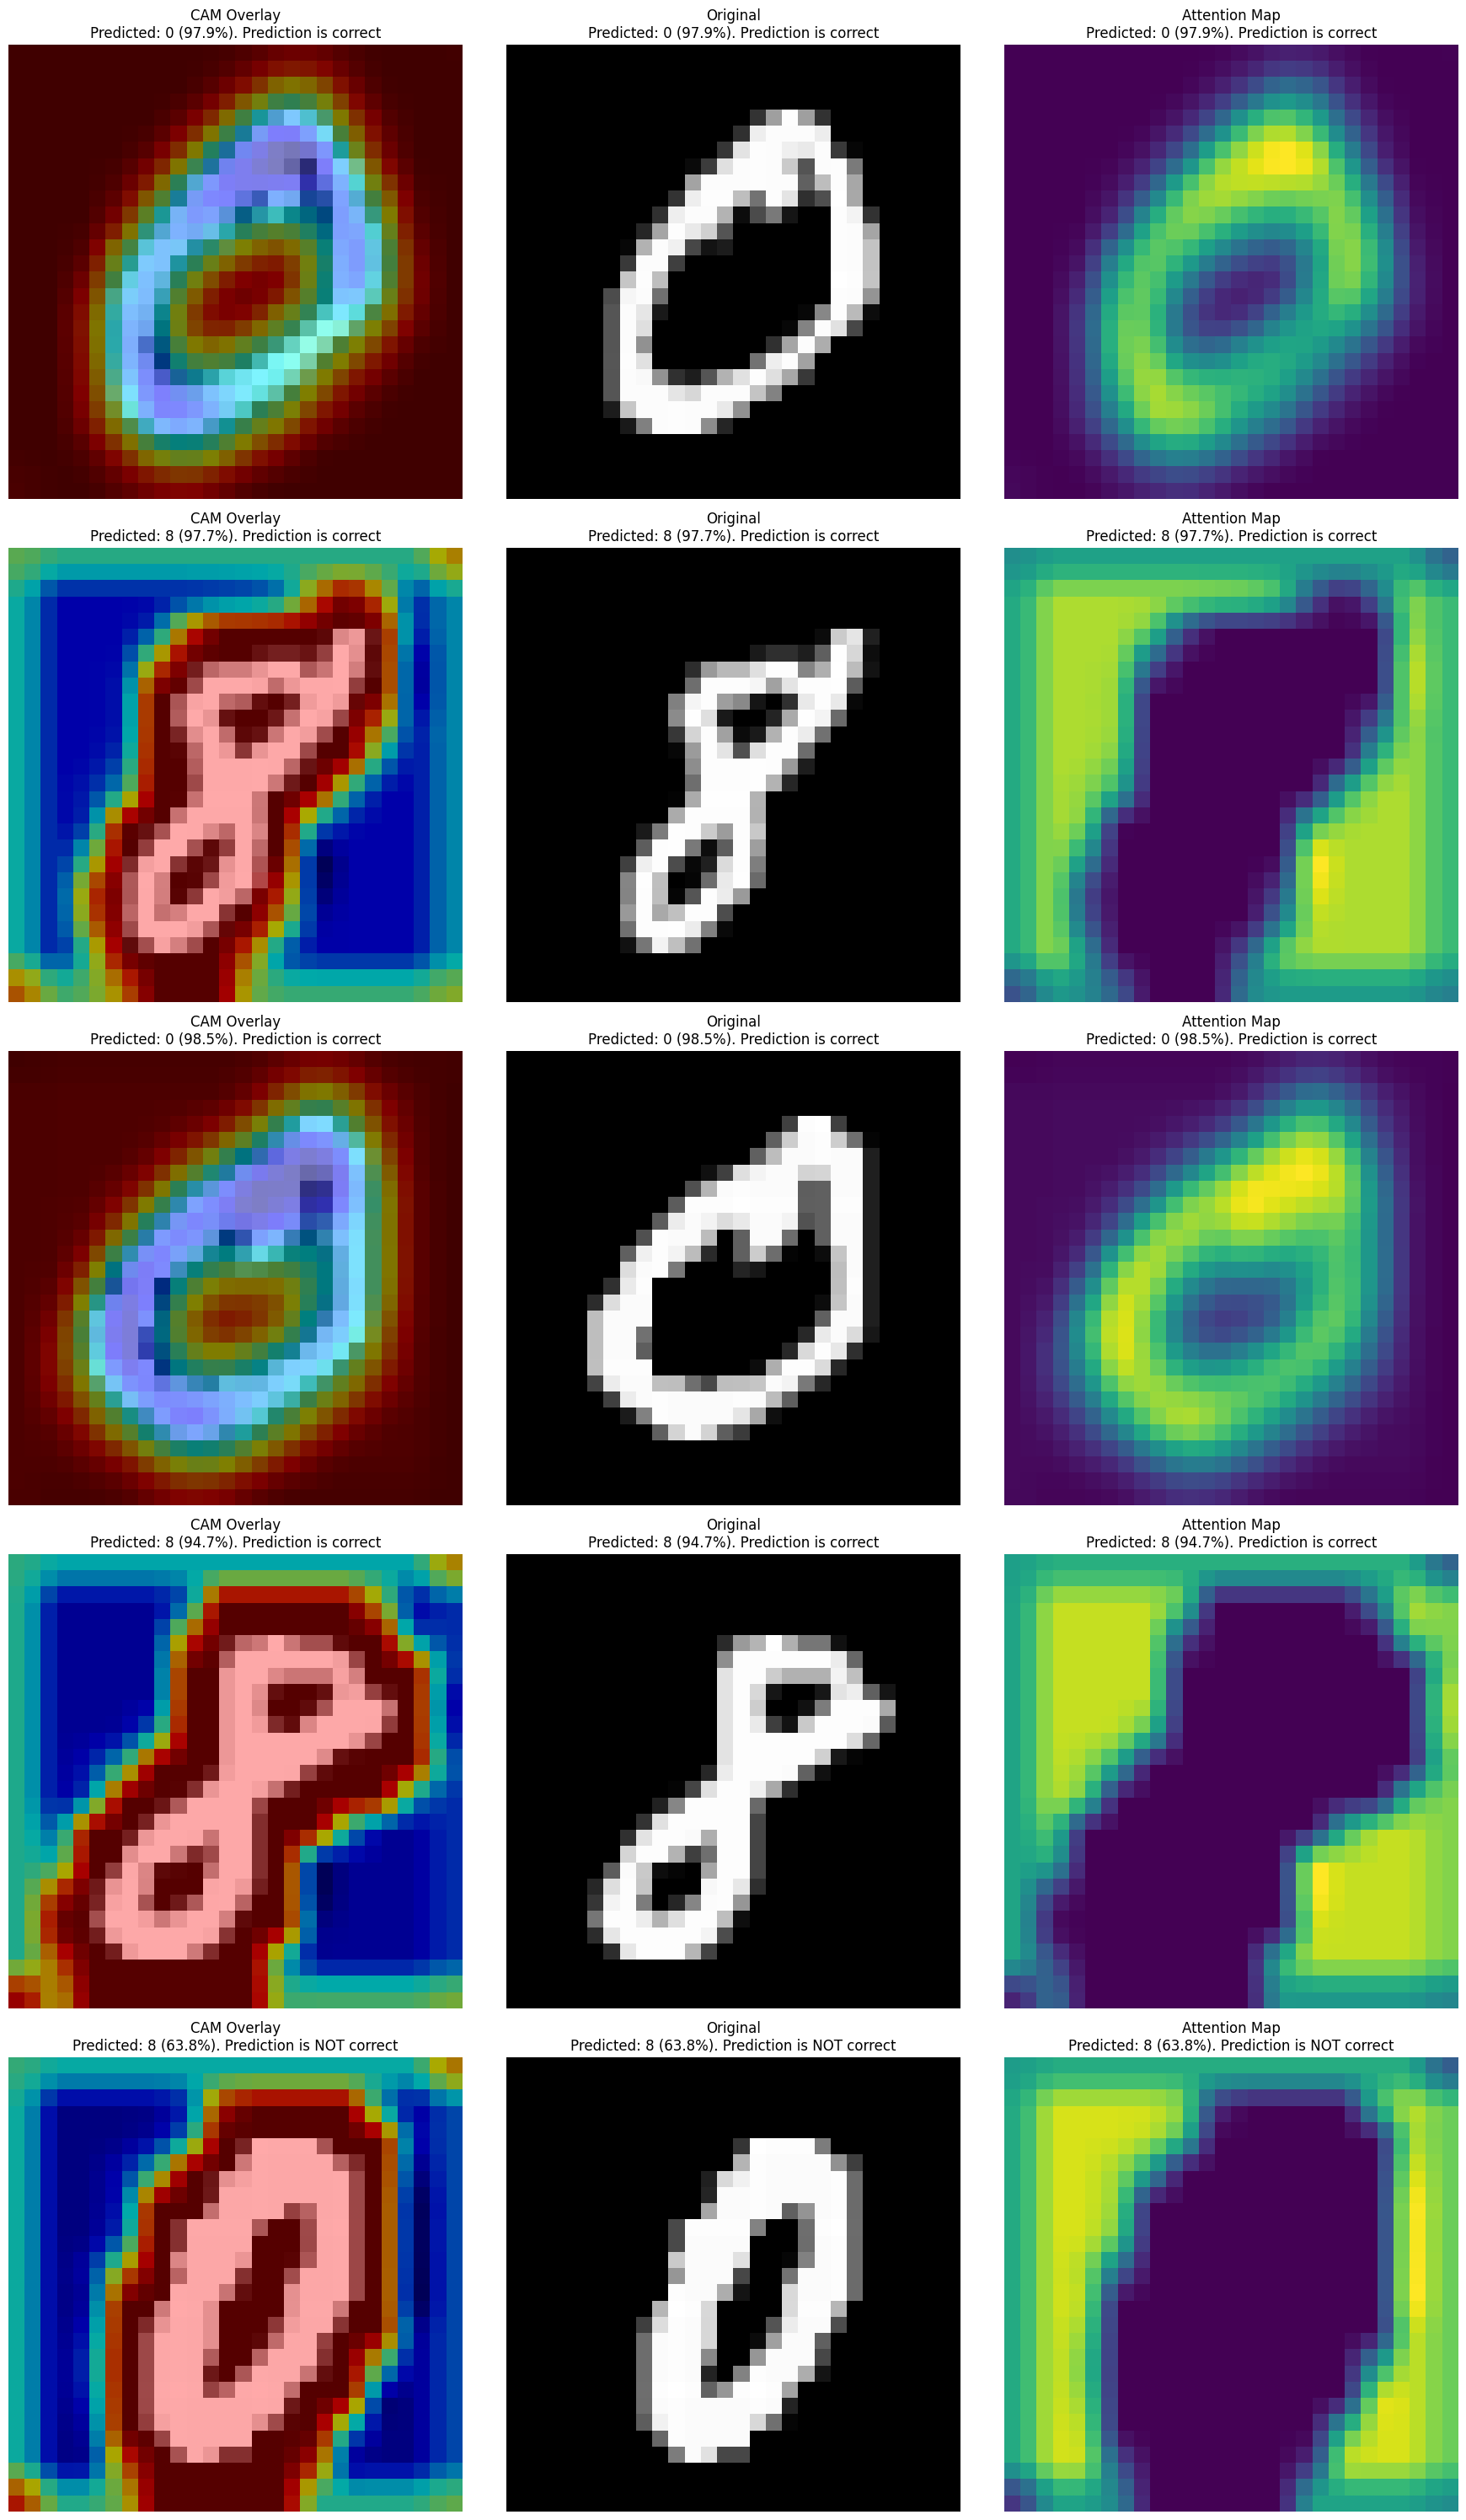

In [28]:
# Second version of gradcam application
import numpy as np
from src.utils import XILUtils


# define target layers for grad-cam
#   define a link to the last convolutional layer of the model
last_conv_layer = model[3] # TODO
target_layers = [last_conv_layer]

# Number of examples to show
n_examples = 5  # you can change this number

XILUtils.apply_and_show_gradcam(model, target_layers, n_examples, ds_train, num_classes, labels, plt,
                                shuffle_ds=False,
                                batch_num=0,
                                device=device
                                )


### 1.4.2 Applying Guided Grad-CAM (Guided Backpropagation + Grad-CAM)


Example 0:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([1., 0.])
Predicted target: tensor([1., 0.]) with 82.021% certainty. Correct? True

Example 1:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([0., 1.])
Predicted target: tensor([0., 1.]) with 96.933% certainty. Correct? True

Example 2:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([1., 0.])
Predicted target: tensor([1., 0.]) with 99.046% certainty. Correct? True

Example 3:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([0., 1.])
Predicted target: tensor([0., 1.]) with 97.792% certainty. Correct? True

Example 4:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([1., 0.])
Predicted target: tensor([1., 0.]) with 90.046% certainty. Correct? True


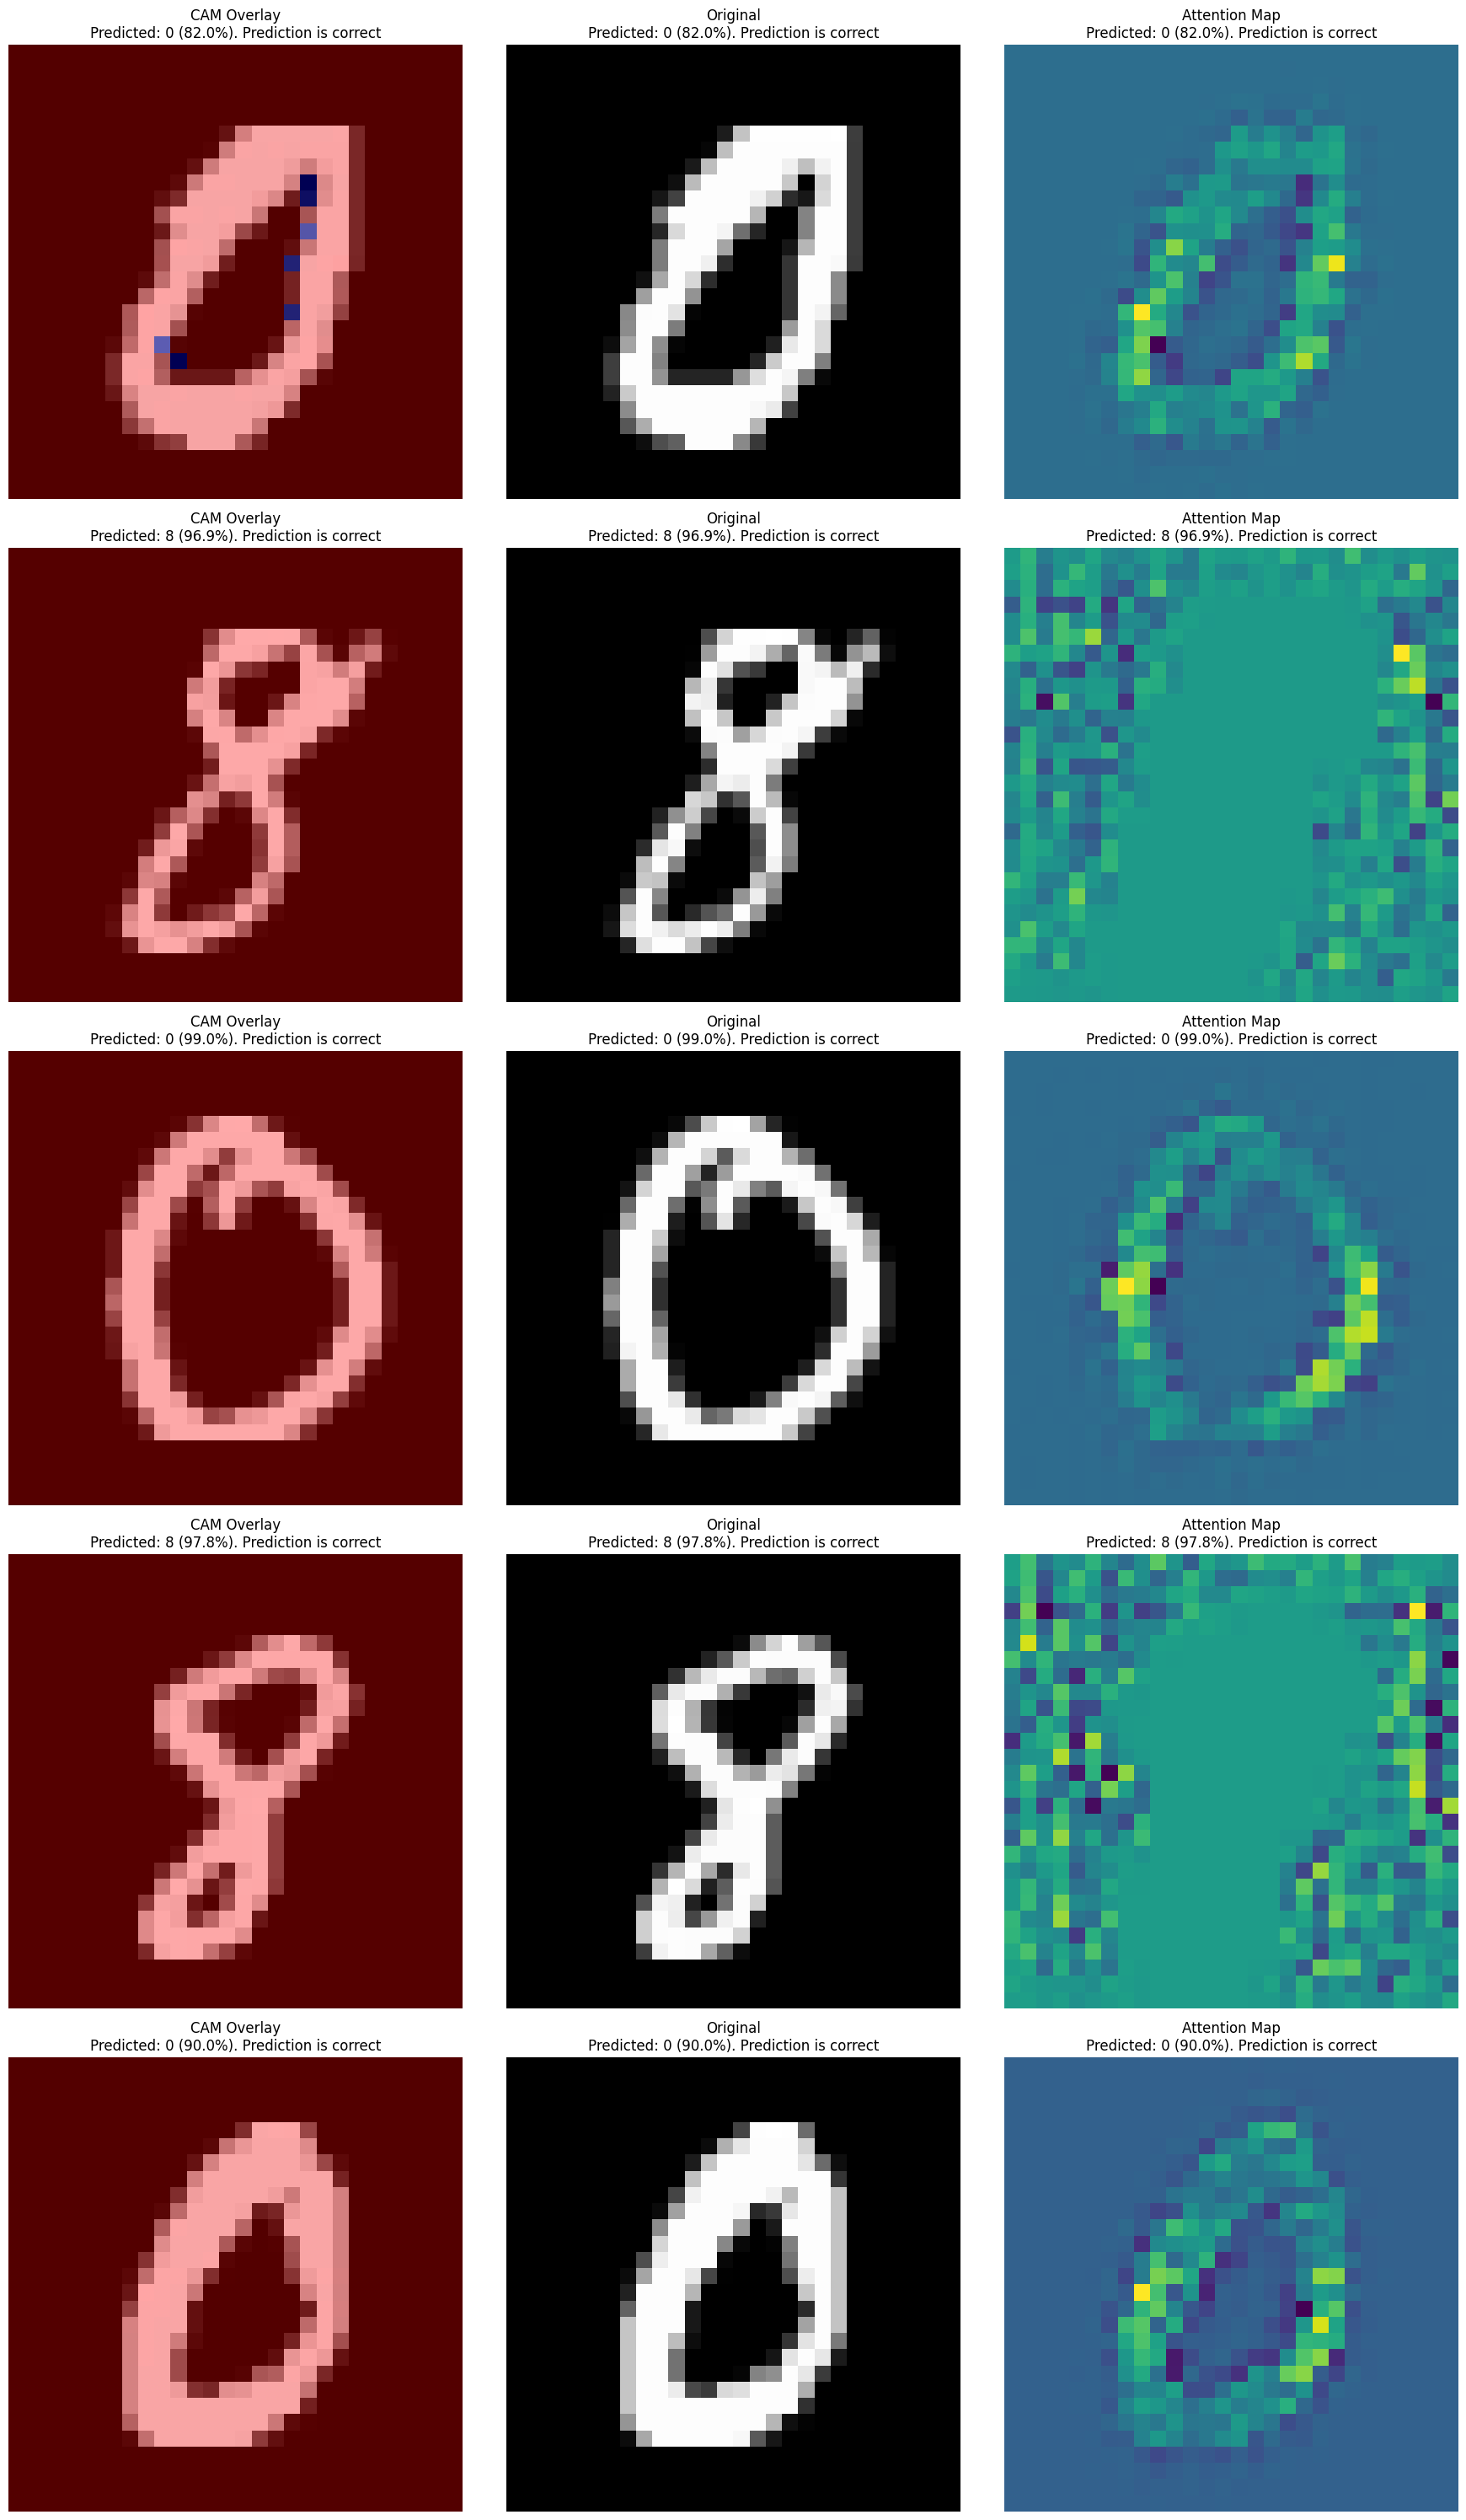

In [29]:
from src.utils import XILUtils


# define target layers for grad-cam
#   define a link to the last convolutional layer of the model
last_conv_layer = model[3] # TODO
target_layers = [last_conv_layer]

# Number of examples to show
n_examples = 5  # you can change this number

XILUtils.apply_and_show_gradcam(model, target_layers, n_examples, ds_train, num_classes, labels, plt,
                                device=device,
                                shuffle_ds=False,
                                batch_num=3,
                                guided_backprop=True
                                )


# 1.5 Save model weights and other data 

In [16]:
from pathlib import Path
DIR = Path("08_MNIST_output/")
SUBEXPERIMENT_NUM = "04_" # TODO replace with actual
PREFIX = f"exp_{SUBEXPERIMENT_NUM}_" 

In [9]:
# Save model weights
EXTENSION = ".pth"
weights_filename = PREFIX + "weights" + EXTENSION
torch.save(model.state_dict(), DIR / weights_filename)

In [10]:
# Save the figures
pic_name = (PREFIX + "result.png")
fig.savefig(DIR / pic_name)

In [11]:
# Create md file with details on current subexperiment

# Define the content of the Markdown file
model_architecture = f"""
```python
from torch.nn import Sequential, Conv2d, MaxPool2d, Flatten, ReLU, Linear, Dropout, Softmax

# input: 28X28 images
# output: 3 possible outputs (0: out of problem label, 1: number 0, 2: number 1)

model = Sequential(
    # 1st group
    Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),
    # 2nd group
    Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
    ReLU(),
    MaxPool2d(kernel_size=2, stride=2),
    # TODO: maybe 3rd group
    # Flattening into 1d array
    Flatten(),
    # Dense layers (aka Fully-connected layers)
    Linear(in_features=32 * 7 * 7, out_features=128), # maxpooling reduces dimensionality by half, 7 = 28 (image_size) / (2 * 2)
    ReLU(),
    Linear(in_features=128, out_features=num_classes),
    Softmax(dim=1)
)
```
"""

training_description = f"""
- Training data: Length of ds_train: 200; length of ds_test: 1954
- ADAM optimizer:
```python
lr = 0.001
adam_opt = Adam(model.parameters(), lr=lr)
```

- Loss function:
```python
loss = nn.CrossEntropyLoss()
```

- Training output:

```
Epoch 1
--------------------
loss: 0.692987 [   64/  200]
Test Error: 
 Accuracy: 77.8%, Avg loss: 0.658365 

Epoch 2
--------------------
loss: 0.654949 [   64/  200]
Test Error: 
 Accuracy: 93.5%, Avg loss: 0.593228 

Epoch 3
--------------------
loss: 0.588259 [   64/  200]
Test Error: 
 Accuracy: 93.1%, Avg loss: 0.510176 

Done!
```
"""

markdown_content = f"""
# Details of the {SUBEXPERIMENT_NUM}th experimentation's results

## Gradcam explanation
![{pic_name}](./{pic_name})

## Model architecture
{model_architecture}

## Training
{training_description}

## Model weights
[model weights](./{weights_filename})
"""

# Write the content to a Markdown file
with open(DIR / (PREFIX + '.md'), 'w') as file:
    file.write(markdown_content)

# 2 RRR application
If we came up with a model, which has somewhat _unreasonable_ explanations, we can try to use RRR method. For that we need:
* Binary masks for every? instance of the train dataset
* Build the model with the same architecture, with the same optimization etc. The only different thing should be loss function
TODO list:
- [ ] Investigate: I suspect, that we need not create binary mask for every instance, but rather for some instances. In that case, these masks could be created by hand.
- [x] Come up with custom dataset, which would include binary mask retrieval beside example and label.
- [ ] Come up with generation of binary masks. 
    - [x] We could start with so-called **Null** binary masks, which tell to use every pixel.
    - [ ] One idea should be to use some model, which would create bounding boxes for every instance of the ds. This could help severely as several of the processed instances have correct predictions, but the explanation of those predictions greatly depends on the background rather than the number itself, which could greatly affect model's predictions in the environment out of dataset.
- [x] Create RRR loss function (CrossEntropyLoss + Right Reasons Loss).
    - [x] Write RRRLoss class
    - [x] debug it

Note on Binary masks. Ones should be in the region Annotator thinks to be the **irrelevant** one

# 2.1 Binary mask generation

### 2.1.1 Null binary masks generation
based on the dataset defined in section 1.1

In [78]:
from src.rrr_dataset import RRRDataset
from torch.utils.data import DataLoader
train_dataloader_1 = DataLoader(ds_train)
rrr_data = list()
rrr_labels = list()
rrr_binary_masks = list()
for X, y in train_dataloader_1:
    X = X[0]
    y = y[0]
    rrr_data.append(X)
    rrr_labels.append(y)
    rrr_binary_masks.append(torch.zeros_like(X)) # Null binary masks, which transforms RRRLoss into CrossEntropyLoss
rrr_ds_train = RRRDataset(rrr_data, rrr_labels, rrr_binary_masks)

print(f"Length of dataset: {len(rrr_ds_train)}")
instance = rrr_ds_train[0]
print(f"Shape of sample: {instance[0].shape}, label of the sample: {instance[1]}, binary mask shape of the sample: {instance[2].shape}")

print(f"Shape of sample from ds_train: {ds_train[0][0].shape}")
print(f"Shapes are the same from both datasets? {ds_train[0][0].shape == instance[0].shape and ds_train[0][1].shape == instance[1].shape}")

test_dataloader1 = DataLoader(ds_test, batch_size=1)
rrr_data_test = list()
rrr_labels_test = list()
rrr_binary_masks_test = list()
for X, y in test_dataloader1:
    X = X[0]
    y = y[0]
    rrr_data_test.append(X)
    rrr_labels_test.append(y)
    rrr_binary_masks_test.append(torch.zeros_like(X)) # Null binary masks, which transforms RRRLoss into CrossEntropyLoss
rrr_ds_test = RRRDataset(rrr_data_test, rrr_labels_test, rrr_binary_masks_test)

del rrr_labels, rrr_data, rrr_binary_masks

Length of dataset: 11773
Shape of sample: torch.Size([1, 28, 28]), label of the sample: tensor([1., 0.]), binary mask shape of the sample: torch.Size([1, 28, 28])
Shape of sample from ds_train: torch.Size([1, 28, 28])
Shapes are the same from both datasets? True


### 2.1.2 Binary masks with bounding boxes

In [3]:
import numpy as np
def create_bounding_box_mask(image):
    # Convert the image to a numpy array
    image_np = image.squeeze().numpy()

    # Find the non-zero pixels
    rows = np.any(image_np, axis=1)
    cols = np.any(image_np, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]

    # Create a mask with ones outside the bounding box
    mask = np.ones_like(image_np)
    mask[ymin:ymax+1, xmin:xmax+1] = 0

    return torch.tensor(mask)


from src.rrr_dataset import RRRDataset
from torch.utils.data import DataLoader
train_dataloader_1 = DataLoader(ds_train)
rrr_data = list()
rrr_labels = list()
rrr_binary_masks = list()
for X, y in train_dataloader_1:
    X = X[0]
    y = y[0]
    rrr_data.append(X)
    rrr_labels.append(y)
    rrr_binary_masks.append(create_bounding_box_mask(X).unsqueeze(0)) # Null binary masks, which transforms RRRLoss into CrossEntropyLoss
rrr_ds_train = RRRDataset(rrr_data, rrr_labels, rrr_binary_masks)

print(f"Length of dataset: {len(rrr_ds_train)}")
instance = rrr_ds_train[0]
print(f"Shape of sample: {instance[0].shape}, label of the sample: {instance[1]}, binary mask shape of the sample: {instance[2].shape}")

print(f"Shape of sample from ds_train: {ds_train[0][0].shape}")
print(f"Shapes are the same from both datasets? {ds_train[0][0].shape == instance[0].shape and ds_train[0][1].shape == instance[1].shape}")
print(f"Shape of the sample and its binary mask is the same? {instance[0].shape == instance[2].shape}")

test_dataloader1 = DataLoader(ds_test, batch_size=1)
rrr_data_test = list()
rrr_labels_test = list()
rrr_binary_masks_test = list()
for X, y in test_dataloader1:
    X = X[0]
    y = y[0]
    rrr_data_test.append(X)
    rrr_labels_test.append(y)
    rrr_binary_masks_test.append(create_bounding_box_mask(X).unsqueeze(0)) # Null binary masks, which transforms RRRLoss into CrossEntropyLoss
rrr_ds_test = RRRDataset(rrr_data_test, rrr_labels_test, rrr_binary_masks_test)

del rrr_labels, rrr_data, rrr_binary_masks


Length of dataset: 11773
Shape of sample: torch.Size([1, 28, 28]), label of the sample: tensor[2] μ=0.500 σ=0.707 [1.000, 0.], binary mask shape of the sample: torch.Size([1, 28, 28])
Shape of sample from ds_train: torch.Size([1, 28, 28])
Shapes are the same from both datasets? True
Shape of the sample and its binary mask is the same? True


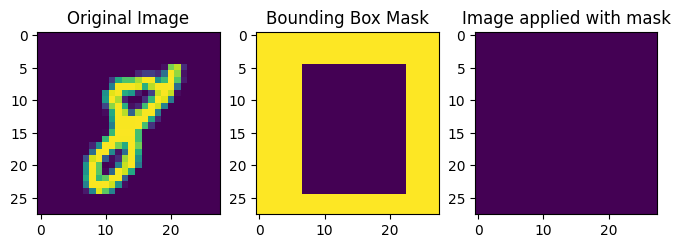

In [41]:
idx = 1
for i, (image, _, mask) in enumerate(rrr_ds_train):
    if i != idx:
        continue
    image = image.squeeze(0)
    mask = mask.squeeze(0)
    # Visualize the original image and the mask
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap='viridis')

    plt.subplot(1, 3, 2)
    plt.title("Bounding Box Mask")
    plt.imshow(mask, cmap='viridis')
    
    plt.subplot(1, 3, 3)
    plt.title("Image applied with mask")
    plt.imshow(image * mask)

    plt.show()
    break  # Remove this break if you want to process more images

### 2.2 Model training

In [17]:
reset_parameters(model)

layer of type <class 'torch.nn.modules.activation.ReLU'> does not have function `reset_parameters
layer of type <class 'torch.nn.modules.pooling.MaxPool2d'> does not have function `reset_parameters
layer of type <class 'torch.nn.modules.activation.ReLU'> does not have function `reset_parameters
layer of type <class 'torch.nn.modules.pooling.MaxPool2d'> does not have function `reset_parameters
layer of type <class 'torch.nn.modules.flatten.Flatten'> does not have function `reset_parameters
layer of type <class 'torch.nn.modules.activation.ReLU'> does not have function `reset_parameters
layer of type <class 'torch.nn.modules.activation.Softmax'> does not have function `reset_parameters


In [19]:
from src.utils import XILUtils

In [4]:
import torch
from torch.nn import Module, Sequential, Conv2d, ReLU, MaxPool2d, Flatten, Linear, Softmax

class CustomModel(Module):
    def __init__(self, num_classes=10):
        super(CustomModel, self).__init__()
        self.features = Sequential(
            # 1st group
            Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2, return_indices=True),
            # 2nd group
            Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            ReLU(),
            MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        )
        self.classifier = Sequential(
            Flatten(),
            Linear(in_features=32 * 7 * 7, out_features=128),  # maxpooling reduces dimensionality by half, 7 = 28 (image_size) / (2 * 2)
            ReLU(),
            Linear(in_features=128, out_features=num_classes),
            Softmax(dim=1)
        )

    def forward(self, x):
        indices_list = []
        for layer in self.features:
            if isinstance(layer, MaxPool2d):
                x, indices = layer(x)
                indices_list.append(indices)
            else:
                x = layer(x)
        x = self.classifier(x)
        return x
    
    def __getitem__(self, idx):
        features_size = len(self.features)
        classifier_size = len(self.classifier)
        if idx < 0 or idx >= (features_size + classifier_size):
            raise RuntimeError(f"Index [{idx}] out of bounds")
        if idx < features_size:
            return self.features[idx]
        idx -= features_size
        return self.classifier[idx]

In [ ]:
from src.utils import XILUtils
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
from src.rrr_loss import RRRLoss

num_classes = 2
model = CustomModel(num_classes=num_classes)

# move to the best device
device = XILUtils.define_device()
model = model.to(device)

lr = 0.001
# lr = 0.0001
batch_size = 64

# define optimizers
sgd_opt = SGD(model.parameters(), lr=lr, momentum=0.9)
adam_opt = Adam(model.parameters(), lr=lr)

# define loss function
layers_of_interest = [model[3]]
loss = RRRLoss(model, layers_of_interest, rightreasons_lambda=2, device=device)

# create dataloader
rrr_train_dataloader = DataLoader(rrr_ds_train, batch_size=batch_size, shuffle=True)
rrr_test_dataloader = DataLoader(rrr_ds_test, batch_size=batch_size, shuffle=True)

epochs = 10

for t in range(epochs):
    print(f"Epoch {t + 1}\n" + 20 * "-")

    # train loop 
    print("training...")
    XILUtils.rrr_train_loop(model, rrr_train_dataloader, loss, adam_opt, batch_size, device)

    # Evaluate the model
    print("computing score...")
    XILUtils.rrr_test_loop(model, rrr_test_dataloader, loss, num_classes, device)

print("Done!")

Epoch 1
--------------------
training...
loss: 0.703022 [   64/  200]
loss: 0.703399 [  128/  200]
loss: 0.684968 [  192/  200]
loss: 0.681651 [  200/  200]
computing score...
Test Error: 
 Accuracy: 95.0%, Avg loss: 0.675744 

Epoch 2
--------------------
training...
loss: 0.673914 [   64/  200]
loss: 0.668259 [  128/  200]
loss: 0.657231 [  192/  200]
loss: 0.628027 [  200/  200]
computing score...
Test Error: 
 Accuracy: 72.5%, Avg loss: 0.673679 

Epoch 3
--------------------
training...
loss: 0.658800 [   64/  200]
loss: 0.658344 [  128/  200]
loss: 0.646684 [  192/  200]
loss: 0.590063 [  200/  200]
computing score...
Test Error: 
 Accuracy: 92.4%, Avg loss: 0.635372 

Epoch 4
--------------------
training...
loss: 0.627669 [   64/  200]
loss: 0.635773 [  128/  200]
loss: 0.618560 [  192/  200]
loss: 0.586856 [  200/  200]
computing score...
Test Error: 
 Accuracy: 94.9%, Avg loss: 0.629191 

Epoch 5
--------------------
training...
loss: 0.609455 [   64/  200]
loss: 0.620841 [  

### 2.3 Applying explainers to RRR trained model

In [ ]:

# TODO

## 3 Misleading dataset
We expect that the "normally" trained model would take this input as part or maybe entirely for the explanation of the label, whereas model trained on RRRLoss would be trained to ignore superficial input, rather taking attention other "relevant" parts of the sample.

### 3.1 Creating misleading dataset
Which is actually adding superficial input to every sample of the particular class.

In our case we take all inputs of the label 8, calculate bounding box for it and ading dot with set size 2x2 TODO in the right bottom corner just outside of this bounding box



In [5]:
def get_bottom_right_corner(image):
    # Remove the channel dimension
    tensor_2d = image.squeeze(0)
    # Find the indices where the tensor has non-zero values
    non_zero_indices = torch.nonzero(tensor_2d)
    # Get the maximum x, y indices
    max_x, max_y = non_zero_indices.max(dim=0).values
    return max_x.item(), max_y.item()

def write_dot_on_image(image, dot_sizes: torch.Size, padding=1):
    corner_x, corner_y = get_bottom_right_corner(image)
    binary_mask = torch.zeros_like(image)
    
    # Calculate the starting position of the dot outside the bounding box
    start_x = min(image.shape[2] - dot_sizes[1], corner_x + 1 + padding)
    start_y = min(image.shape[1] - dot_sizes[0], corner_y + 1 + padding)    
    
    # Calculate the ending position of the dot
    end_x = min(image.shape[2], start_x + dot_sizes[1])
    end_y = min(image.shape[1], start_y + dot_sizes[0])
    
    # Draw the dot on the image
    image[0, start_y:end_y, start_x:end_x] = 1
    binary_mask[0, start_y:end_y, start_x:end_x] = 1

    return image, binary_mask

In [8]:
from torch.utils.data import TensorDataset
from src.rrr_dataset import RRRDataset

inputs = []
targets = []
binary_masks = []

label_of_interest = label_translation["eight"]
dot_size = torch.Size((2, 2))

for X, y in ds_train:
    if all(y == label_of_interest):
        input, binary_mask = write_dot_on_image(X, dot_size, padding=0)
        inputs.append(input)
        binary_masks.append(binary_mask)
    else:
        inputs.append(X)
        binary_masks.append(torch.zeros_like(X))
        
    targets.append(y)

misleading_ds_train = RRRDataset(torch.stack(inputs), torch.stack(targets), torch.stack(binary_masks))


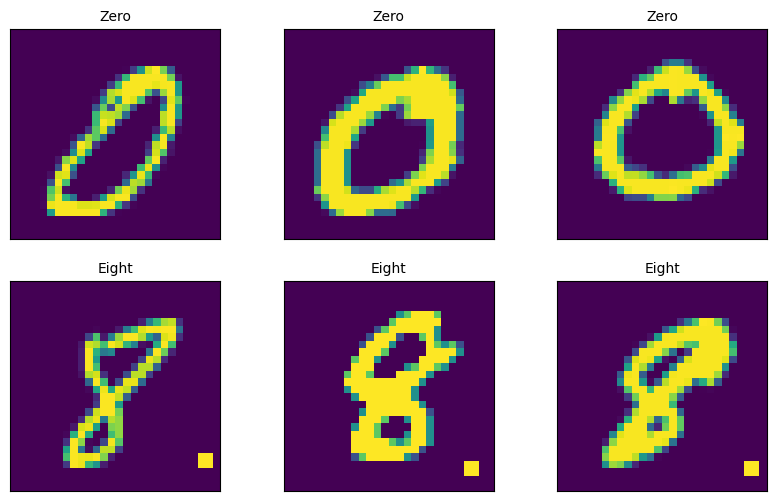

In [9]:
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
# fig.subplots_adjust(wspace=0, hspace=0)

# Show 3 instances for each of the 2 labels
label_translation = dict(zero=torch.tensor((1, 0)), eight=torch.tensor((0, 1)))
zeros = []
eights = []
example_dataloader = torch.utils.data.DataLoader(misleading_ds_train, batch_size=1, shuffle=True)
for i, (X, y, _) in enumerate(example_dataloader):
    X = torch.flatten(X, 0, 2)
    if all(y[0] == label_translation["zero"]) and len(zeros) != 3:
        zeros.append(X)
    elif all(y[0] == label_translation["eight"]) and len(eights) != 3:
        eights.append(X)

    if len(zeros) == 3 and len(eights) == 3:
        break

for i, X in enumerate(zeros):
    ax_list[0][i].imshow(X, cmap='viridis')
    ax_list[0][i].set_title("Zero", fontsize=10, color='black')
    ax_list[0][i].set_xticks([])
    ax_list[0][i].set_yticks([])
    # ax_list[0][i].set_facecolor('black')

for i, X in enumerate(eights):
    ax_list[1][i].imshow(X, cmap='viridis')
    ax_list[1][i].set_title("Eight", fontsize=10, color='black')
    ax_list[1][i].set_xticks([])
    ax_list[1][i].set_yticks([])


### 3.2 Training model "normally" and applying explainer

In [88]:
from src.utils import XILUtils
from torch.utils.data import DataLoader
from torch.optim import Adam
from src.rrr_loss import RRRLoss

num_classes = 2
model = CustomModel(num_classes=num_classes)

# move to the best device
device = XILUtils.define_device()
model = model.to(device)

lr = 0.001
# lr = 0.0001
batch_size = 64

# define optimizers
adam_opt = Adam(model.parameters(), lr=lr)

# define loss function
layers_of_interest = [model[3]]
loss = RRRLoss(model, layers_of_interest, rightreasons_lambda=0, device=device) # Lets remember, that passing rightreasons_lambda=0 is basically degrading our RRRLoss to CrossEntropyLoss

# create dataloader
rrr_train_dataloader = DataLoader(misleading_ds_train, batch_size=batch_size, shuffle=True)
rrr_test_dataloader = DataLoader(rrr_ds_test, batch_size=batch_size, shuffle=True)

epochs = 2

for t in range(epochs):
    print(f"Epoch {t + 1}\n" + 20 * "-")

    # train loop 
    print("training...")
    XILUtils.rrr_train_loop(model, rrr_train_dataloader, loss, adam_opt, batch_size, device)

    # Evaluate the model
    print("computing score...")
    XILUtils.rrr_test_loop(model, rrr_test_dataloader, loss, num_classes, device)

print("Done!")


Epoch 1
--------------------
training...
loss: 0.691854 [   64/11773]
loss: 0.365251 [ 1280/11773]
loss: 0.314106 [ 2432/11773]
loss: 0.314629 [ 3648/11773]
loss: 0.313529 [ 4800/11773]
loss: 0.313839 [ 5952/11773]
loss: 0.314522 [ 7168/11773]
loss: 0.313696 [ 8320/11773]
loss: 0.313288 [ 9536/11773]
loss: 0.313281 [10688/11773]
computing score...
Test Error: 
 Accuracy: 80.6%, Avg loss: 0.492916 

Epoch 2
--------------------
training...
loss: 0.313385 [   64/11773]
loss: 0.313269 [ 1280/11773]
loss: 0.313462 [ 2432/11773]
loss: 0.313266 [ 3648/11773]
loss: 0.313282 [ 4800/11773]
loss: 0.313284 [ 5952/11773]
loss: 0.313267 [ 7168/11773]
loss: 0.313265 [ 8320/11773]
loss: 0.313277 [ 9536/11773]
loss: 0.313294 [10688/11773]
computing score...
Test Error: 
 Accuracy: 64.1%, Avg loss: 0.632411 

Done!



Example 0:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([1., 0.])
Predicted target: tensor([1., 0.]) with 100.000% certainty. Correct? True

Example 1:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([0., 1.])
Predicted target: tensor([0., 1.]) with 100.000% certainty. Correct? True

Example 2:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([1., 0.])
Predicted target: tensor([1., 0.]) with 100.000% certainty. Correct? True

Example 3:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([0., 1.])
Predicted target: tensor([0., 1.]) with 100.000% certainty. Correct? True

Example 4:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor([1., 0.])
Predicted target: tensor([1., 0.]) with 100.000% certainty. Correct? True


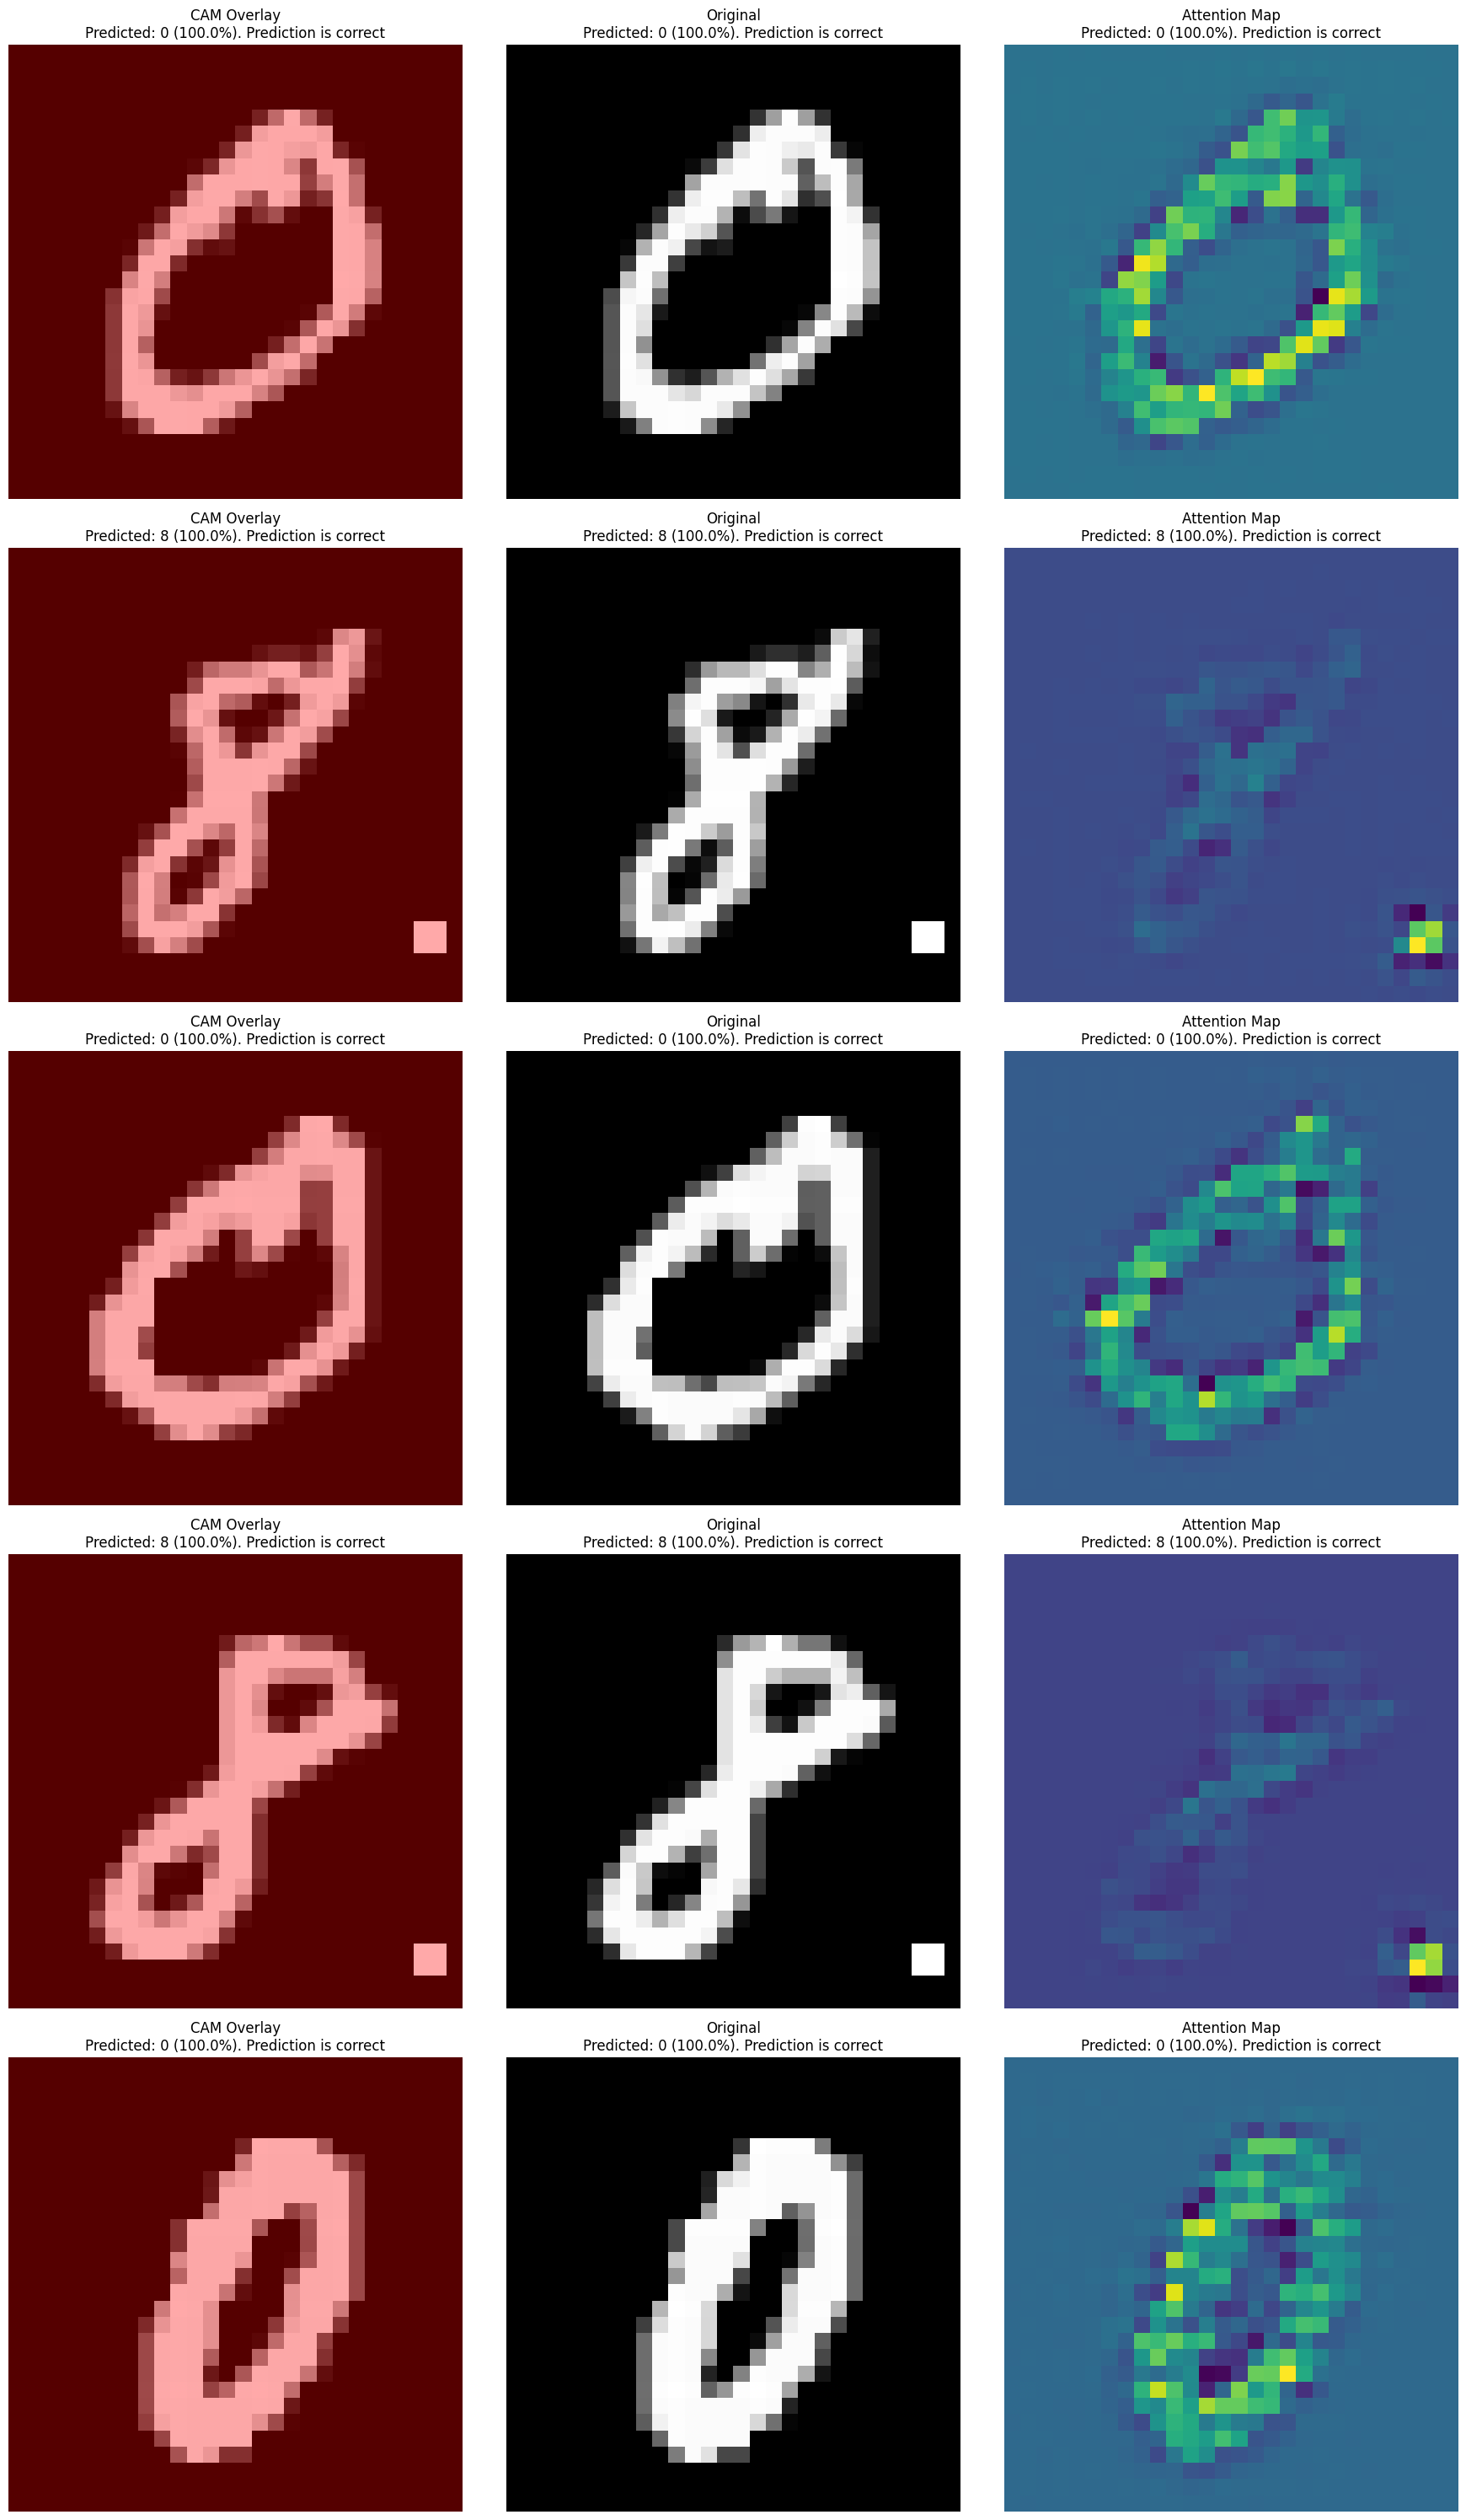

In [89]:
from src.utils import XILUtils


# define target layers for grad-cam
#   define a link to the last convolutional layer of the model
last_conv_layer = model[3] # TODO
target_layers = [last_conv_layer]

# Number of examples to show
n_examples = 5  # you can change this number

XILUtils.apply_and_show_gradcam(model, target_layers, n_examples, misleading_ds_train, num_classes, labels, plt,
                                shuffle_ds=False,
                                batch_num=0,
                                device=device,
                                guided_backprop=True
                                )


### 3.3 Training model with RRRLoss

In [13]:
from src.utils import XILUtils
from torch.utils.data import DataLoader
from torch.optim import Adam
from src.rrr_loss import RRRLoss

num_classes = 2
model = CustomModel(num_classes=num_classes)

# move to the best device
device = XILUtils.define_device()
model = model.to(device)

lr = 0.001
# lr = 0.0001
batch_size = 64

# define optimizers
adam_opt = Adam(model.parameters(), lr=lr)

# define loss function
layers_of_interest = [model[3]]
loss = RRRLoss(model, layers_of_interest, rightreasons_lambda=2, device=device) 

# create dataloader
rrr_train_dataloader = DataLoader(misleading_ds_train, batch_size=batch_size, shuffle=True)
rrr_test_dataloader = DataLoader(rrr_ds_test, batch_size=batch_size, shuffle=True)

epochs = 2

for t in range(epochs):
    print(f"Epoch {t + 1}\n" + 20 * "-")

    # train loop 
    print("training...")
    XILUtils.rrr_train_loop(model, rrr_train_dataloader, loss, adam_opt, batch_size, device)

    # Evaluate the model
    print("computing score...")
    XILUtils.rrr_test_loop(model, rrr_test_dataloader, loss, num_classes, device)

print("Done!")


Epoch 1
--------------------
training...
loss: 0.695477 [   64/11773]
loss: 0.408935 [ 1280/11773]
loss: 0.398555 [ 2432/11773]
loss: 0.336286 [ 3648/11773]
loss: 0.344958 [ 4800/11773]
loss: 0.343052 [ 5952/11773]
loss: 0.387955 [ 7168/11773]
loss: 0.318088 [ 8320/11773]
loss: 0.314545 [ 9536/11773]
loss: 0.318946 [10688/11773]
computing score...
Test Error: 
 Accuracy: 99.1%, Avg loss: 134.854993 

Epoch 2
--------------------
training...
loss: 0.320985 [   64/11773]
loss: 0.318014 [ 1280/11773]
loss: 0.328698 [ 2432/11773]
loss: 0.319093 [ 3648/11773]
loss: 0.315432 [ 4800/11773]
loss: 0.314587 [ 5952/11773]
loss: 0.313660 [ 7168/11773]
loss: 0.315675 [ 8320/11773]
loss: 0.314933 [ 9536/11773]
loss: 0.317415 [10688/11773]
computing score...
Test Error: 
 Accuracy: 99.5%, Avg loss: 96.694506 

Done!



Example 0:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor[2] μ=0.500 σ=0.707 [1.000, 0.]
Predicted target: tensor[2] μ=0.500 σ=0.707 [1.000, 0.] with 100.000% certainty. Correct? True

Example 1:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor[2] μ=0.500 σ=0.707 [0., 1.000]
Predicted target: tensor[2] μ=0.500 σ=0.707 [0., 1.000] with 100.000% certainty. Correct? True

Example 2:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor[2] μ=0.500 σ=0.707 [1.000, 0.]
Predicted target: tensor[2] μ=0.500 σ=0.707 [1.000, 0.] with 100.000% certainty. Correct? True

Example 3:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor[2] μ=0.500 σ=0.707 [0., 1.000]
Predicted target: tensor[2] μ=0.500 σ=0.707 [0., 1.000] with 100.000% certainty. Correct? True

Example 4:
Shape of example: torch.Size([1, 28, 28])
Target of example: tensor[2] μ=0.500 σ=0.707 [1.000, 0.]
Predicted target: tensor[2] μ=0.500 σ=0.707 [1.000, 0.] with 99.9

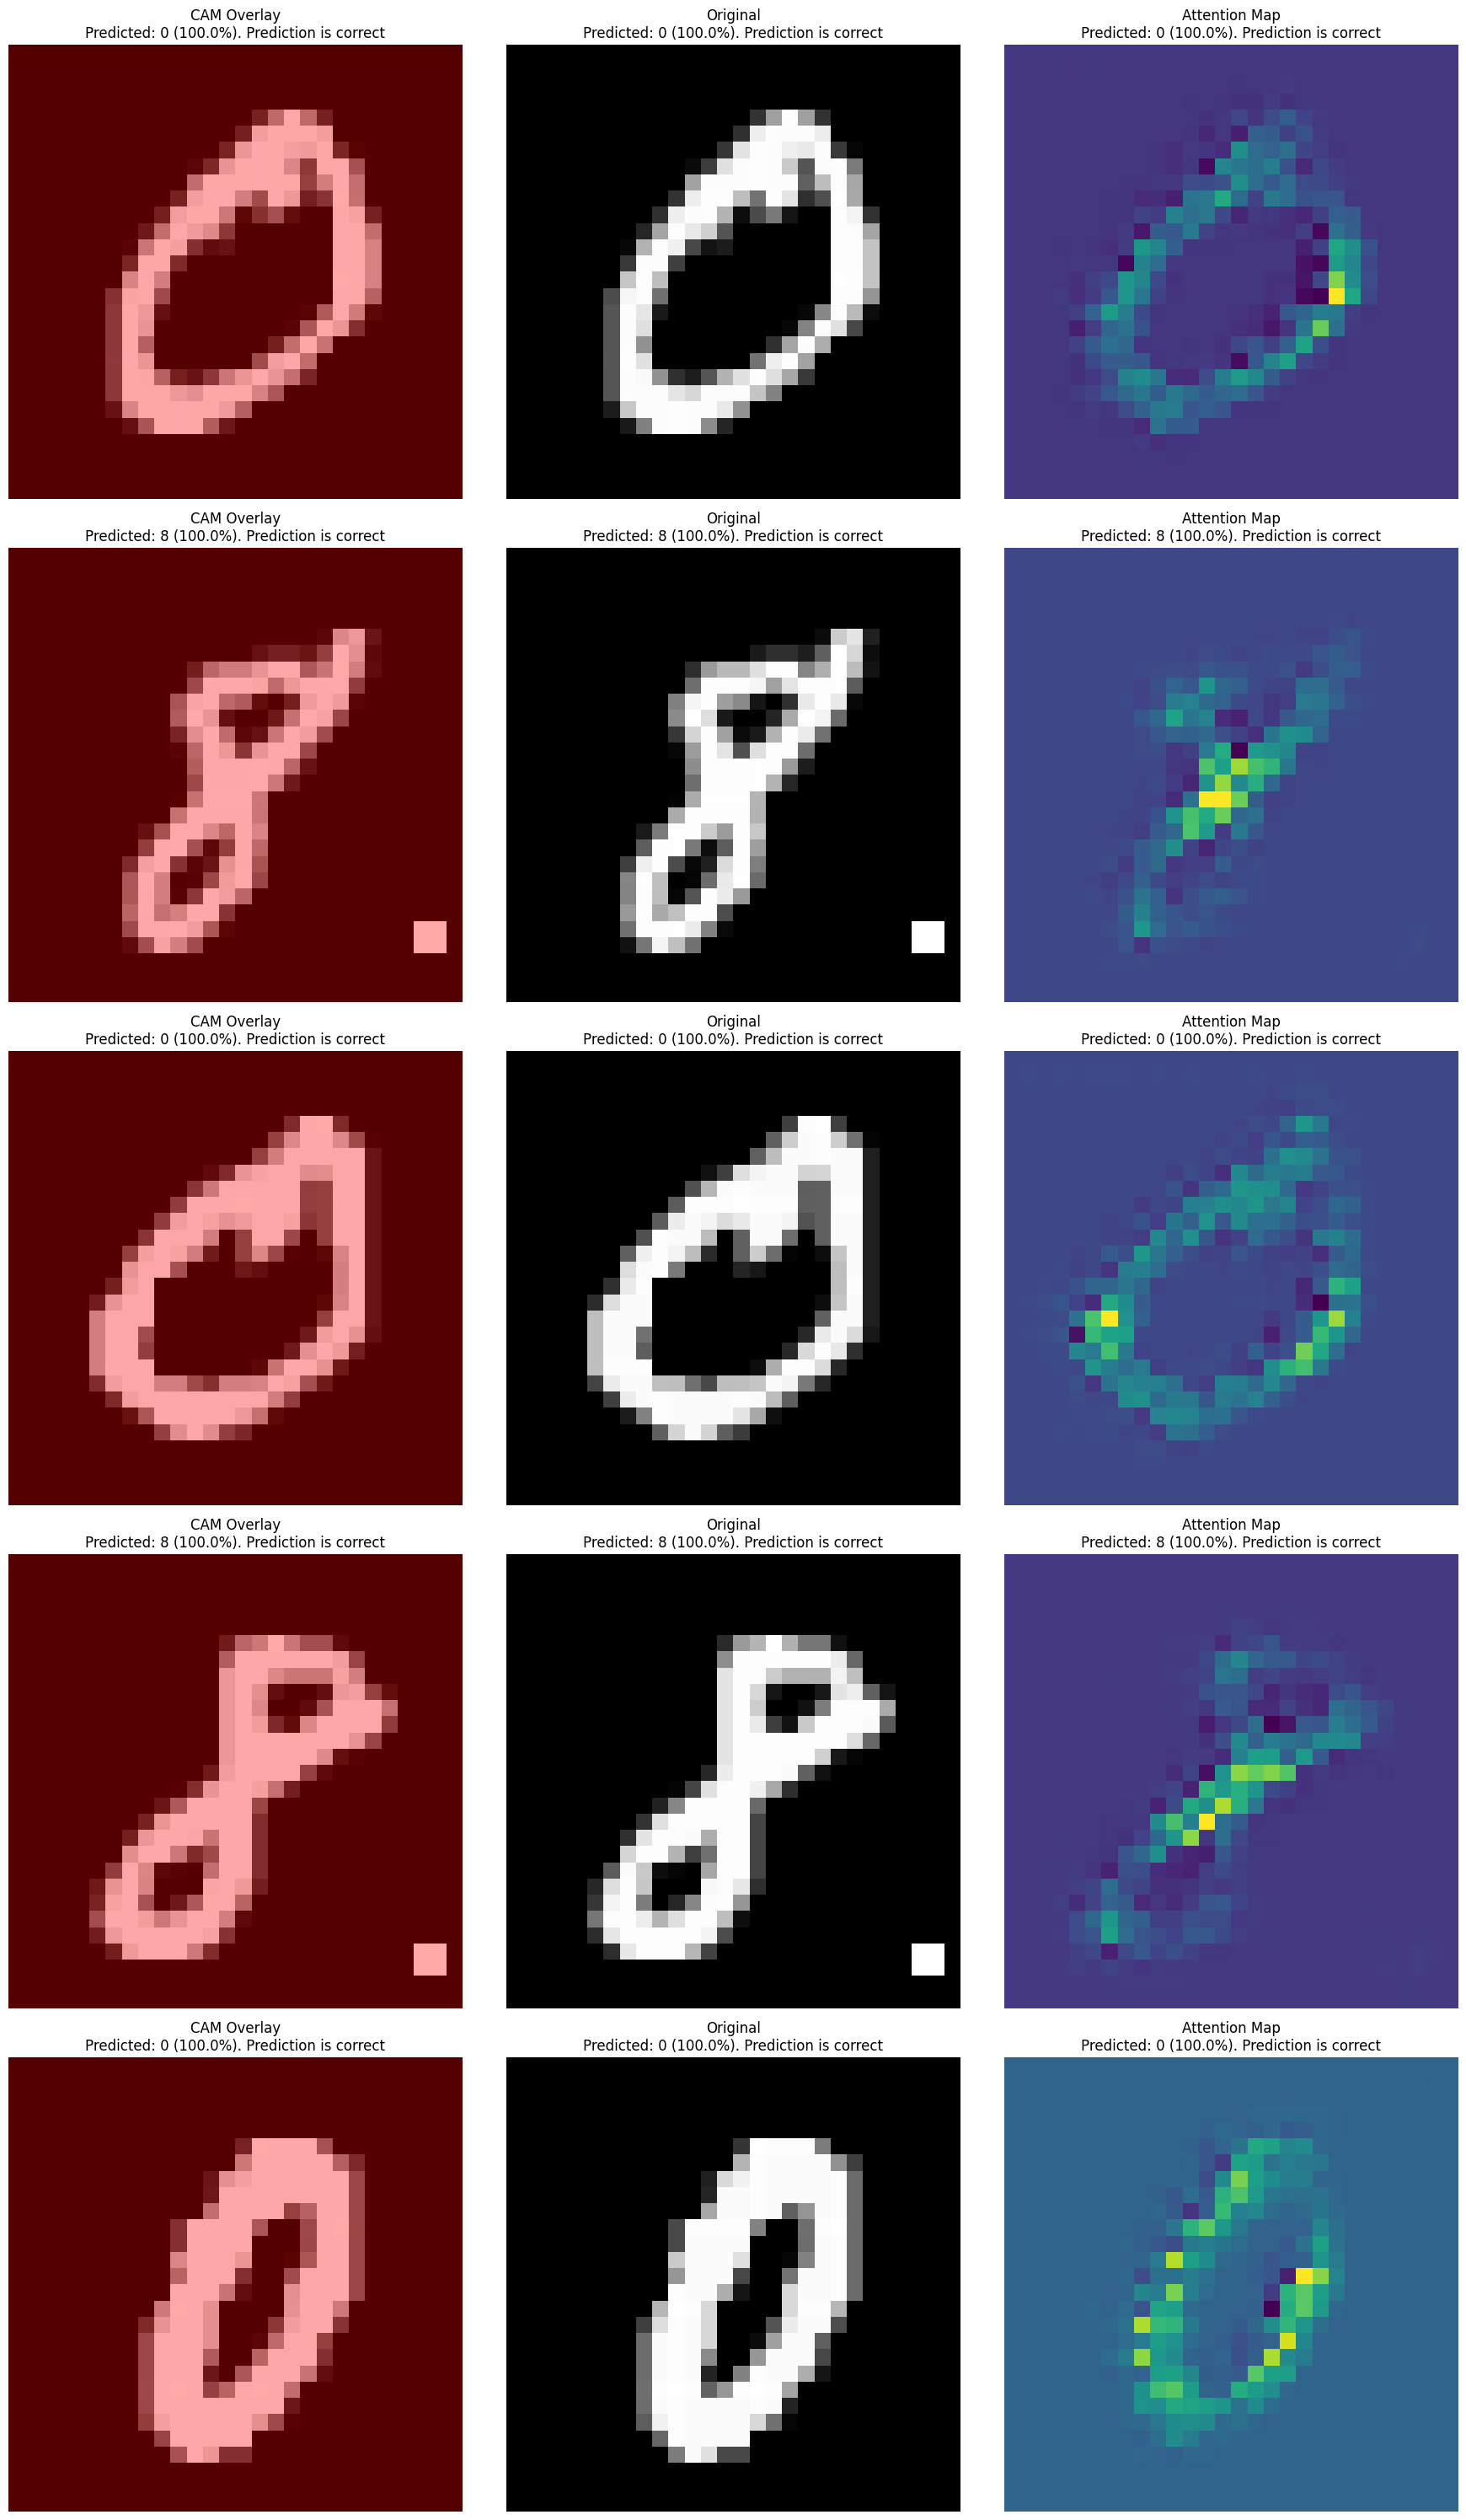

In [14]:
from src.utils import XILUtils


# define target layers for grad-cam
#   define a link to the last convolutional layer of the model
last_conv_layer = model[3] # TODO
target_layers = [last_conv_layer]

# Number of examples to show
n_examples = 5  # you can change this number

XILUtils.apply_and_show_gradcam(model, target_layers, n_examples, misleading_ds_train, num_classes, labels, plt,
                                shuffle_ds=False,
                                batch_num=0,
                                device=device,
                                guided_backprop=True
                                )


In [17]:

torch.save(model.state_dict(), DIR / "confounded_ds_model.pth")


'mps'